In [ ]:
pip install rasterio -t /content/drive/MyDrive/packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import sys
sys.path.append("/content/drive/MyDrive/packages")

In [2]:
import os
import rasterio
import numpy as np

In [5]:
import shutil
val_folder = "/content/drive/MyDrive/SpaceNet/output/val/images"
train_folder = "/content/drive/MyDrive/SpaceNet/output/train/images"
for filename in os.listdir(val_folder):
  shutil.move(os.path.join(val_folder, filename), os.path.join(train_folder, filename))

In [ ]:
input_folder = r"/content/drive/MyDrive/SpaceNet/train/AOI_5_Khartoum_Train/RGB-PanSharpen"
output_folder = r"/content/drive/MyDrive/SpaceNet/output/train/images/"
selected_channels = [3,4,5]  # Example: selecting the fifth, third, and second channels
selected_channels = [1,2,3]
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_folder, filename)
        output_filename = os.path.splitext(filename)[0] + ".png"
        output_path = os.path.join(output_folder, output_filename)

        with rasterio.open(input_path) as src:
            # Read the selected channels
            selected_channels_data = src.read(selected_channels)

            # Normalize the data to 0-255 range (for PNG)
            min_val = selected_channels_data.min()
            max_val = selected_channels_data.max()
            normalized_data = ((selected_channels_data - min_val) * 255.0 / (max_val - min_val)).astype(np.uint8)

            # Create a new image with the selected channels
            profile = src.profile
            profile.update(count=len(selected_channels), dtype=np.uint8)

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(normalized_data)
print("Processing completed.")

Processing completed.


In [17]:
# prompt: 输出文件夹下有多少个文件
print(f"Number of files in the output folder: {len(os.listdir('/content/drive/MyDrive/SpaceNet/output/train/labels'))}")

Number of files in the output folder: 2160


In [12]:
rm -rf /content/drive/MyDrive/SpaceNet/output/val

In [14]:
rm -rf /content/drive/MyDrive/SpaceNet/output/train/labels

In [16]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from tqdm import tqdm

# 设置数据目录（图像和 geojson 同目录）
image_dir = '/content/drive/MyDrive/SpaceNet/train/AOI_5_Khartoum_Train/RGB-PanSharpen'  # 替换为你自己的路径
geojson_dir = '/content/drive/MyDrive/SpaceNet/train/AOI_5_Khartoum_Train/geojson/buildings'
label_output_dir = '/content/drive/MyDrive/SpaceNet/output/train/labels'
os.makedirs(label_output_dir, exist_ok=True)

# 获取所有 geojson 文件
geojson_files = [f for f in os.listdir(geojson_dir) if f.endswith('.geojson')]
min_width_px = 0
min_height_px = 0
for geojson_file in tqdm(geojson_files, desc="转换中"):
    image_name = geojson_file.replace('buildings_', 'RGB-PanSharpen_').replace('.geojson', '.tif')
    image_path = os.path.join(image_dir, image_name)
    geojson_path = os.path.join(geojson_dir, geojson_file)

    if not os.path.exists(image_path):
        print(f"图像缺失，跳过：{image_name}")
        continue

    try:
        with rasterio.open(image_path) as src:
            image_data = src.read()
            transform = src.transform
            crs = src.crs
            height, width = image_data.shape[1:]

        gdf = gpd.read_file(geojson_path).to_crs(crs)

        label_file = os.path.join(label_output_dir, image_name.replace('.tif', '.txt'))
        with open(label_file, 'w') as f:
            for _, row in gdf.iterrows():
                minx, miny, maxx, maxy = row.geometry.bounds
                x1, y1 = ~transform * (minx, miny)
                x2, y2 = ~transform * (maxx, maxy)

                x_center = ((x1 + x2) / 2) / width
                y_center = ((y1 + y2) / 2) / height

                box_w = abs(x2 - x1)
                box_h = abs(y2 - y1)
                # 过滤条件：小于阈值则跳过
                if box_w < min_width_px or box_h < min_height_px:
                    continue
                box_width = abs(x2 - x1) / width
                box_height = abs(y2 - y1) / height

                # 仅写入合法框
                if 0 < box_width <= 1 and 0 < box_height <= 1:
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")
    except Exception as e:
        print(f"{geojson_file} 转换失败：{e}")

转换中: 100%|██████████| 1012/1012 [03:23<00:00,  4.96it/s]


In [ ]:
import os

# 文件夹路径
folder_path = r"/content/drive/MyDrive/SpaceNet/output/train/images"

# 遍历文件夹
for filename in os.listdir(folder_path):
    if "(1)" in filename:
        file_path = os.path.join(folder_path, filename)
        # 判断是不是文件
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"已删除: {file_path}")

In [1]:
import os
import random
import shutil
# 参数配置
root_dir = '/content/drive/MyDrive/SpaceNet/output'
train_img_dir = os.path.join(root_dir, 'train/images')
train_lbl_dir = os.path.join(root_dir, 'train/labels')
val_img_dir = os.path.join(root_dir, 'val/images')
val_lbl_dir = os.path.join(root_dir, 'val/labels')

# 创建 val 目录
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# 随机划分 15%
image_files = [f for f in os.listdir(train_img_dir) if f.endswith('.png')]
val_sample = random.sample(image_files, int(len(image_files) * 0.15))

# 移动文件
for fname in val_sample:
    lbl_name = fname.replace('.png', '.txt')
    shutil.move(os.path.join(train_img_dir, fname), os.path.join(val_img_dir, fname))
    shutil.move(os.path.join(train_lbl_dir, lbl_name), os.path.join(val_lbl_dir, lbl_name))

print(f"划分完成，验证集数量：{len(val_sample)}")


划分完成，验证集数量：324


In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17496/17496), 16.56 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (11997/11997), done.


In [5]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 50 \
--data /content/drive/MyDrive/SpaceNet/spacenet.yaml \
--weights yolov5s.pt --cache --multi-scale

流式输出内容被截断，只能显示最后 5000 行内容。
  with torch.cuda.amp.autocast(amp):
      28/49      9.21G    0.04426     0.1386          0        595        512:  78% 90/115 [00:27<00:07,  3.14it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      9.21G    0.04426     0.1387          0        539        640:  79% 91/115 [00:27<00:07,  3.16it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      9.21G    0.04425     0.1386          0        362        576:  80% 92/115 [00:28<00:07,  3.13it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      9.21

In [16]:
!python /content/yolov5/detect.py \
  --weights yolov5/runs/train/exp2/weights/best.pt \
  --source /content/drive/MyDrive/SpaceNet/output/train/images/RGB-PanSharpen_AOI_5_Khartoum_img1.png \
  --img-size 640 \
  --line-thickness 1 \
  --save-txt \
  --save-conf

detect: weights=['yolov5/runs/train/exp2/weights/best.pt'], source=/content/drive/MyDrive/SpaceNet/output/train/images/RGB-PanSharpen_AOI_5_Khartoum_img1.png, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/SpaceNet/output/train/images/RGB-PanSharpen_AOI_5_Khartoum_img1.png: 640x640 19 buildings, 11.4ms
Speed: 0.6ms pre-process, 11.4ms inference, 158.4ms NMS per image at shape (1, 3, 640, 640)


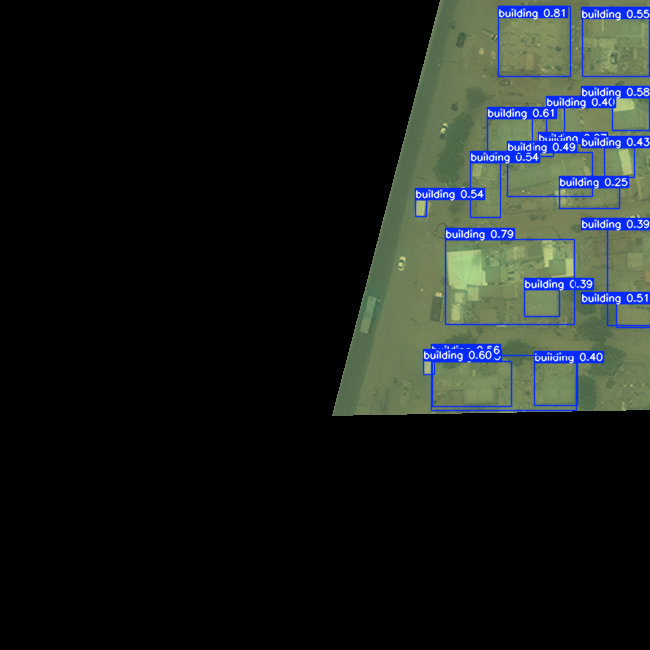

In [17]:
from IPython.display import Image, display
display(Image(filename='/content/yolov5/runs/detect/exp5/RGB-PanSharpen_AOI_5_Khartoum_img1.png'))